# Estimando Aluguel com Redes Neurais

## Introdução

Apesar da população, Florianópolis é uma cidade vasta e esparsa, com vários bairros que funcionam quase independentemente uns dos outros. Além disso, aluguel na cidade pode variar muito dependendo da região. Esse projeto pretende criar um modelo para que, dado as características de um apartamento, possamos estimar o valor do aluguel.

O projeto tem como segunda finalidade estudar e exemplificar o uso de redes neurais usando Python.


## Coleta de Dados

Os dados foram coletados a partir do site **VivaReal.com.br**, usando os scripts encontrados em `downloaddata.py`. Para garantir reproducibilidade, os dados usados nessa análise estão salvos no arquivo `rentals.json`. Ao total, foram coletadas informações de 3102 vagas de aluguel na cidade de Florianópolis.


## Limpandos os dados

Ao longo do projeto, usaremos Pandas para visualizar e limpar dados, combinado à biblioteca `GeoPandas` para visualização de mapas. O primeiro passo do processo é carregar o json com os dados:

In [245]:
# Setup
import json 
import matplotlib.pyplot as plt
import geopandas as geo
import numpy as np
from shapely.geometry import Point
import pandas as pd


%matplotlib notebook

data = pd.read_json("rentals.json")

print("Colunas disponíveis: "+ ", ".join(data.columns))

Colunas disponíveis: account, accountLicenseNumber, accountLogo, accountName, accountPagePath, accountRole, additionalFeatures, address, area, areaUnit, backgroundImage, baseRentPrice, baseSalePrice, bathrooms, businessId, businessName, cityName, cityUrl, condominiumPrice, constructionStatus, contactAddress, contactCellPhoneNumber, contactLogo, contactName, contactPhoneNumber, countryName, countryUrl, creationDate, currency, currencySymbol, developmentInformation, email, externalId, garages, geoDistance, image, images, iptu, isDevelopmentUnit, latitude, leadEmails, legend, links, listingType, locationId, longitude, neighborhoodName, neighborhoodUrl, numImages, positioning, price, priceValue, promotions, propertyId, propertyTypeId, propertyTypeName, publicationType, rentPeriod, rentPeriodId, rentPrice, rooms, salePrice, saved, showAddress, siteUrl, stateName, stateUrl, suites, thumbnail, thumbnails, title, usageId, usageName, video, zipCode, zoneName, zoneUrl


Ao todo possuímos 77 colunas com diversas informações (inclusive imagens das vagas), porém apenas algumas são necessárias. Além disso, queremos tratar latitude e longitude como pontos no plano cartesiano.

In [252]:
data = data[['area','additionalFeatures','priceValue','bathrooms','condominiumPrice',
             'garages','iptu','latitude', 'longitude', 'neighborhoodName', 'rentPeriodId', 
             'rooms', 'suites', 'usageId']]
data['coord'] = data.apply(lambda x: Point(float(x['longitude']), float(x['latitude'])), 1)
data = geo.GeoDataFrame(data).set_geometry('coord')

/Users/bonet/.virtualenvs/data-python3.5/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Queremos analisar apenas alugueis mensais. Ao verificarmos os dados, podemos ver que existem entradas marcadas como mensais porém com alugueis muito baixos, indicando possível erro no cadastro. Alguns valores de latitude e longitude também estão incorretos. Por isso, precisamos fazer uma triagem do nosso conjunto de dados. De 3100 entradas passamos agora a ter apenas 1228.

<IPython.core.display.Javascript object>


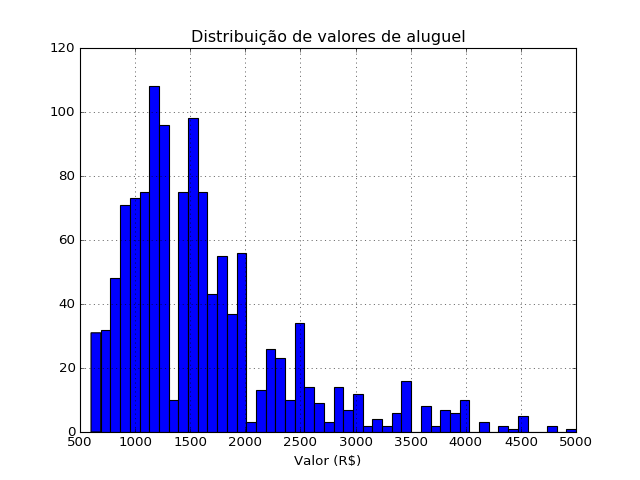

count    1228.000000
mean     1631.399023
std       770.010345
min       600.000000
25%      1100.000000
50%      1450.000000
75%      1900.000000
max      5000.000000
Name: priceValue, dtype: float64

In [254]:
data = data[data.priceValue.between(600, 5000) ]
data = data[data.bathrooms > 0 ]
data = data[data.rooms > 0 ]
data = data[data.rentPeriodId == 'MON' ]
data = data[data.usageId == 'RESIDENCIAL' ]

data['priceValue'].hist(bins=50)
plt.title("Distribuição de valores de aluguel")
plt.xlabel("Valor (R$)")


data.priceValue.describe()


Para visualizarmos melhor, podemos plotar as vagas em cima do mapa de Florianópolis. As cores representam o preço listado do aluguel (veremlho representa valores altos). Os dados cartográficos foram obtidos no site do Inep seguindo atrabés desse [link](ftp://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc250/versao2015/Shapefile/Limites_v2015.zip).

<IPython.core.display.Javascript object>


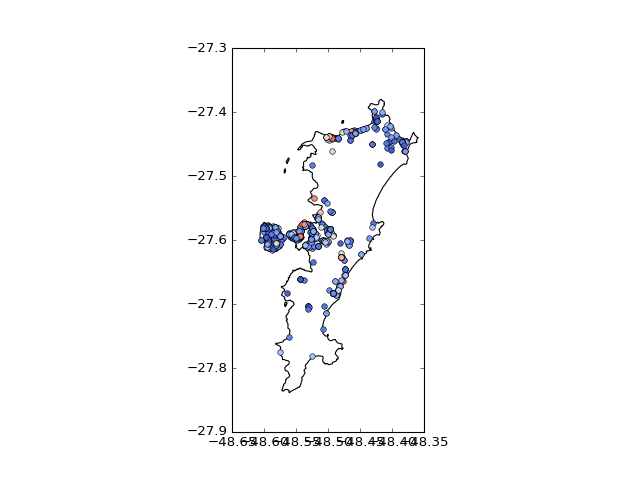

In [255]:
geoFloripa = geo.GeoDataFrame.from_file("geodata/floripa/floripa.shp")

floripaHull = geoFloripa.convex_hull

data =  data[data.coord.map(lambda x: floripaHull.contains(x).bool())]
ax1 = geoFloripa.plot(color="white")

data.plot(ax=ax1, column='priceValue', markersize=5, cmap='coolwarm')

## Redes Neurais Simples

Nossa primeira tentativa será usando de redes neurais simples, com funções disponibilizadas pela biblioteca [Scikit-learn](scikit-learn.org). Apesar de termos diversas informações disponíveis, usaremos apenas 5 delas: número de quartos, número de suítes, número de garagens, area e número de banheiros.

Como alguns imóveis foram cadastrados erroneamente, alguns dados estão em branco. Trocaremos esses valores faltantes por 0. Usaremos 80% dos dados para treino e o restante para testes.


In [257]:
from sklearn.neural_network import MLPRegressor as mlp
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split

model_features = ['rooms','suites','garages', 'area','bathrooms'] 

x = scale(data[model_features].fillna(0.0))

y = scale(data['priceValue'])

x_train, x_test , y_train, y_test = train_test_split(x, y,
                                                     train_size=0.8,
                                                     random_state=42)

/Users/bonet/.virtualenvs/data-python3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:428: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Nossa rede terá duas camadas de 10 neurônios cada uma.

In [258]:
nn = mlp(hidden_layer_sizes=(10,10), max_iter=2000)

nn.fit(x_train, y_train)

MLPRegressor(activation='relu', algorithm='adam', alpha=0.0001,
       batch_size='auto', beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=0.001, max_iter=2000,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

Obtemos os seguintes resultados para a rede treinada:

R2 para treino =0.5444


<IPython.core.display.Javascript object>


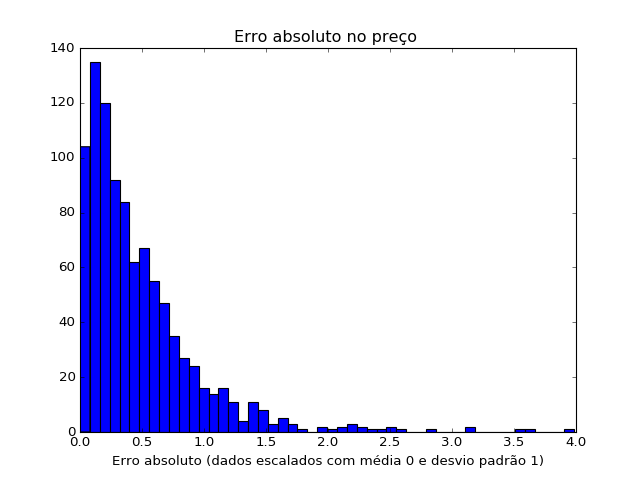

<IPython.core.display.Javascript object>


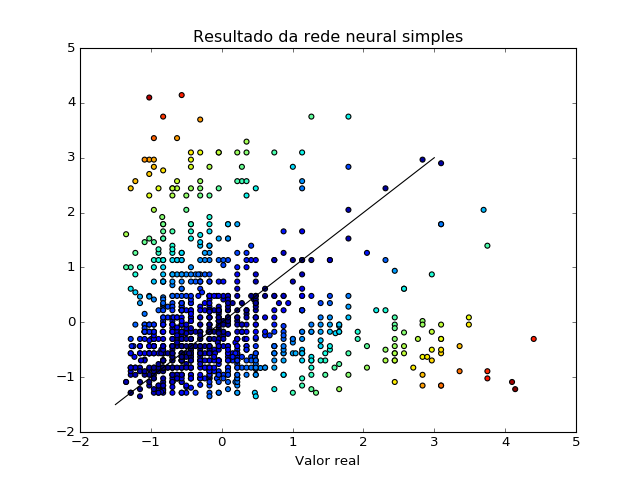

In [263]:
from  scipy import stats

pred_train = nn.predict(x_train)
print("R2 para treino =%.4f" % stats.linregress(pred_train,y_train).rvalue **2)

plt.figure()
plt.hist(abs(pred_train-y_train), bins=50)
plt.title("Erro absoluto no preço ")
plt.xlabel("Erro absoluto (dados escalados com média 0 e desvio padrão 1)")
plt.show()

plt.figure()
plt.scatter(y_train,train[:,5], c=abs(y_train-train[:,5]))
plt.plot([-1.5,3], [-1.5,3], 'k-')
plt.title("Resultado da rede neural simples")
plt.xlabel("Valor estimado")
plt.xlabel("Valor real")
plt.show()

# Redes Neurais Clusterizadas

Como vimos, usar apenas atributos do apartamento como entradas da rede neural não rendeu bons resultados. Isso por que um mesmo apartamento com a mesma área e mesmo número de quartos podem ter uma diferença considerável no valor dependendo de sua localização.

Lidaremos com através do uso de múltiplas redes neurais. Dividiremos os dados de teste em 10 clusters, baseado na latitude, longitude e valor do aluguel. Treinaremos uma ANN para cada um destes clusters.


### Criando os clusters

O primeiro passo será agrupar os dados, onde usaremos KMeans. Novamente, a biblioteca sklearn nos fornece uma implementação simples do algoritmo. Usaremos como propriedas para agrupamento o preço e as coordenadas, a fim de identificar bairros normalmente mais caros. Essa é apenas uma das heurísticas possíveis. Porém, para o caso de testes, removeremos o preço do vetor que representa a coordenada do imóvel.


In [265]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Reproduscibilidade
random_state = 42

# Divide em conjuntos de teste/treino

km_train, km_test = train_test_split(
                       data,
                       train_size = 0.7,
                       random_state=random_state)

# Propriedads das coordendadas
coord_properties = ['longitude', 'latitude']

# Normaliza
coord_scaler = MinMaxScaler()
coords = coord_scaler.fit_transform(km_train[coord_properties])


price_scaler = MinMaxScaler()
prices = price_scaler.fit_transform(km_train[['priceValue']])

# Calcula os centros
centers = KMeans(n_clusters=10, random_state=42).fit(np.c_[coords, prices])


# Remove o preço das coordenadas dos centros
coord_centers = coord_scaler.inverse_transform(centers.cluster_centers_[:,[0,1]])

* Identificação dos clusters

In [266]:
scaler.get_params()

nn_train_coords = km_train[coord_properties]

def euclidean_distance(A,b):
    return np.sum((A-b)**2, axis=1)**0.5

def predict_kmean(centers, X):
    return np.apply_along_axis(lambda x:np.argmin(euclidean_distance(centers,x)), 1, X)

Podemos visualizar agora os clusters de dados:

<IPython.core.display.Javascript object>


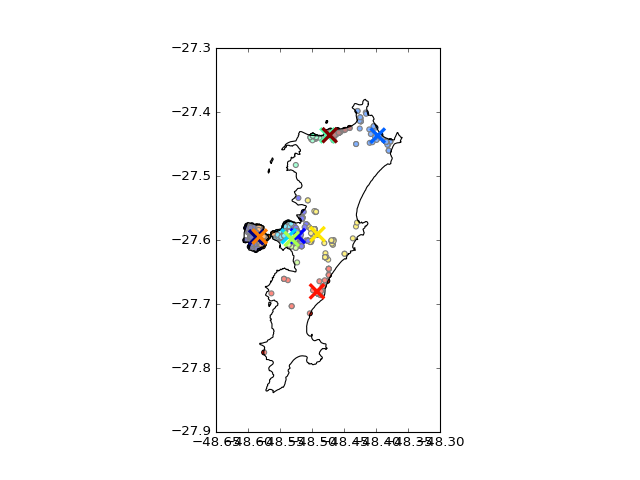

In [268]:


geoFloripa.plot(color="white")

plt.scatter(coord_centers[:, 0], coord_centers[:, 1],
            marker='x', s=169, linewidths=3,
            zorder=10,
            c = np.arange(10))

plt.scatter(np.array(km_train.longitude[:]), 
            np.array(km_train.latitude[:]),
            c = clusters)

plt.show();

O último passo será treinar nossas redes neurais (uma para cada cluster). A função `train_clustered_nn` faz exatamente isso, retornando um array de redes neurais

In [270]:
def train_clustered_nn(X, y, Xcoord, centers):
    """
    Treina uma rede neural clusterizada
    """
    
    n_clusters = len(centers)
    
    cluster_indexes = predict_kmean(centers, Xcoord)
    
    nnetworks = [None]*n_clusters
        
    for i in range(n_clusters):
        print("Treinando rede neural para o cluster %d" % (i,))
        nn = mlp(hidden_layer_sizes=(10,10), max_iter=2000)
        idx = cluster_indexes == i
        nn.fit(X[idx], y[idx])
        nnetworks[i]= nn
    
    print("Treinamento Finalizado! ")
    
    return nnetworks

x_scaler = StandardScaler()
y_scaler = StandardScaler()

nn_train_x = x_scaler.fit_transform(km_train[['rooms','suites','garages', 'area','bathrooms']].fillna(0.0))

nn_train_coords = km_train[['longitude','latitude']]

nn_train_y = y_scaler.fit_transform(km_train[['priceValue']]).ravel()

trained_nnets = train_clustered_nn(nn_train_x, nn_train_y, nn_train_coords, coord_centers)


Treinando rede neural para o cluster 0
Treinando rede neural para o cluster 1
Treinando rede neural para o cluster 2
Treinando rede neural para o cluster 3
Treinando rede neural para o cluster 4
Treinando rede neural para o cluster 5
Treinando rede neural para o cluster 6
Treinando rede neural para o cluster 7
Treinando rede neural para o cluster 8
Treinando rede neural para o cluster 9
Treinamento Finalizado! 


Tendo a rede treinada, a função `predict_clustered_nn` roda a rede neural correta com base nas coordenadas:

In [271]:
def predict_clustered_nn(X, Xcoord, centers, nnets):
    n_clusters = len(centers)
    cluster_indexes = predict_kmean(centers, Xcoord)
    return np.array([nnets[cluster_indexes[i]].predict(X[i].reshape(1, -1)) for i in range(len(X))]).ravel()
    
nn_pred_y = predict_clustered_nn(nn_train_x, nn_train_coords, coord_centers, trained_nnets)

Para o qual teremos os seguintes resultados no conjunto de treino:

R2 para treino =0.7867


<IPython.core.display.Javascript object>


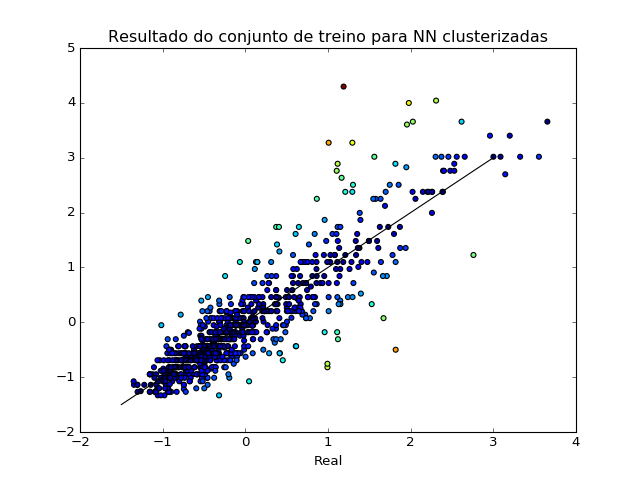

In [273]:
print("R2 para treino =%.4f" % stats.linregress(nn_pred_y,nn_train_y).rvalue **2)
plt.figure()
plt.scatter(nn_pred_y,nn_train_y, c=abs(nn_pred_y-nn_train_y))

plt.plot([-1.5,3], [-1.5,3], 'k-')
plt.title("Resultado do conjunto de treino para NN clusterizadas")
plt.xlabel("Estimado")
plt.xlabel("Real")

plt.show()

Observamos um resultado bem melhor que o obtido anteriormente, com $Rˆ2=0.78$. Agora rodando para o conjunto de de testes:

R2 para treino =0.5430


<IPython.core.display.Javascript object>


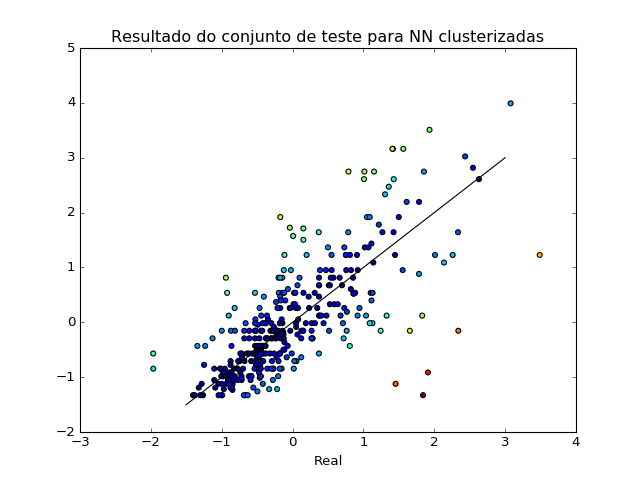

In [275]:
nn_test_x = x_scaler.transform(km_test[['rooms','suites','garages', 'area','bathrooms']].fillna(0.0))

nn_test_coords = km_test[['longitude','latitude']]

nn_test_y = y_scaler.fit_transform(km_test[['priceValue']]).ravel()

nn_test_y_pred = predict_clustered_nn(nn_test_x, nn_test_coords, coord_centers, trained_nnets)

print("R2 para treino =%.4f" % stats.linregress(nn_test_y_pred,nn_test_y).rvalue **2)
plt.figure()
plt.scatter(nn_test_y_pred,nn_test_y, c=abs(nn_test_y_pred-nn_test_y))

plt.plot([-1.5,3], [-1.5,3], 'k-')
plt.title("Resultado do conjunto de teste para NN clusterizadas")
plt.xlabel("Estimado")
plt.xlabel("Real")

plt.show()


# Conclusão

Estudamos aqui a possibilidade de estimar valores de aluguel na cidade de Florianópolis usando dados reais. Para tal, focamos que approaches que fazem o uso de redes neurais. Ao usar redes comuns, tivemos um resultado insatisfatório com $R^2$ de 0.5 para o conjunto de treino.

Em sequência, propusemos uma solução que segmenta o problema através da clusterização dos dados, e em seguida treina uma rede neural para cada um desses subproblemas. Esse método é muito parecido com redes neurais competitivas, por exemplo. Conseguimos melhorar consideralmente nosso resultado para casos de treino ($R^2$ de 0.75), porém para casos de teste temos apenas 0.55.

Podemos alcançar resultados ainda melhores. Apesar de predição de aluguel ser um problema comum para exemplificar algoritmos, o cálculo real involve uma série de parâmetros (como posição em relação ao sol). Por isso, o aumento marginal da troca de algoritmos é ínfimo comparado ao possível ganho obtivo através da melhoria da qualidade dos dados com coleta ou melhor limpeza dos já possuímos. Poderíamos, por exemplo, verificar a distância dos pontos para pontos de interesse como hospitais e escolas, ou então cruzar com bancos de dados de criminalidade. 
